In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd


In [2]:

def create_summary_stats():
    df_customer = pd.read_csv("../data/customers.csv")
    gender_counts = df_customer.groupby(["PLZ", "Geschlecht"]).size().unstack(fill_value=0)
    # Altersstatistik pro PLZ
    age_stats = df_customer.groupby("PLZ")["Alter"].agg(['count', 'mean'])
    # Beide Tabellen zusammenführen
    plz_summary = gender_counts.join(age_stats)
    return(plz_summary)


def prepare_customer_plz_map(df_customer):

    df_plz =  pd.read_csv("../data/plz_coords.csv")
    df_plz_unique = df_plz.drop_duplicates(subset="plz")
    gdf = gpd.read_file("berlin_plz_shapefile/plz.shp")
    gdf['plz'] = gdf['plz'].astype(int)


    df = pd.merge(df_customer, df_plz_unique.loc[:,["name", "plz","lat", "lon"]], left_on="PLZ", right_on="plz", how="left")

    gdf_merged = gdf.merge(df, left_on='plz', right_on='plz', how='left')
    gdf_plot = gdf_merged[gdf_merged['count'].notna()]
    gdf_plot['count'] = gdf_plot['count'].astype(float)
    gdf_plot = gdf_plot.to_crs(epsg=4326)
    return(gdf_plot)


def plot_customer_density_map(gdf):
    # Choroplethenkarte mit Mapbox
    fig = px.choropleth_mapbox(
        gdf,
        geojson=gdf.geometry,
        locations=gdf.index,  # eindeutiger Index für jedes Feature
        color="count",               # Anzahl der Besucher
        hover_name="name",
        hover_data=["plz","count","mean"],
        color_continuous_scale="Viridis",
        mapbox_style="carto-positron",
        zoom=9,
        center={"lat":52.52, "lon":13.405},
    )
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()
    return(fig)    

In [4]:
df = create_summary_stats()
gdf = prepare_customer_plz_map(df)
fig = plot_customer_density_map(gdf)

KeyError: 'PLZ'

In [12]:
import requests
import zipfile
import io

# URL zum Shapefile (Beispiel: Berlin PLZ)
url = "https://tsb-opendata.s3.eu-central-1.amazonaws.com/plz/plz.shp.zip"

# Datei herunterladen
response = requests.get(url)
response.raise_for_status()

# ZIP entpacken
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall()  # entpackt in das aktuelle Verzeichnis


In [86]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from pathlib import Path


def generate_customers(n=1000, seed=42, plz_path="../data/plz_coords.csv"):
    np.random.seed(seed)
    random.seed(seed)

    # ----------------------------
    # PLZ-Verteilung wie vorher
    all_plz = pd.read_csv(plz_path, dtype=str)
    berlin_plz = all_plz[all_plz["name"].str.contains("Berlin", na=False)].copy()
    berlin_plz_list = berlin_plz["plz"].tolist()

    weights = pd.Series(1.0, index=berlin_plz_list)
    for plz in ["10963", "10961", "10965"]:  # Anhalter
        if plz in weights:
            weights[plz] += 5
    for plz in ["10967", "10969", "10997", "10999", "10783", "10785", "10787", "10789"]:  # Anhalter Umgebung
        if plz in weights:
            weights[plz] += 3
    for plz in ["10117", "10178", "10785", "10997", "13353", "12247", "12101", "14195","10827", "12109"]:  # S25
        if plz in weights:
            weights[plz] += 2
    for plz in ["12059", "10245", "10999", "12435"]:  # Konkurrenz
        if plz in weights:
            weights[plz] *= 0.5
    probs = weights / weights.sum()

    plz = np.random.choice(berlin_plz_list, size=n, p=probs.values)

    # ----------------------------
    # Basisattribute
    geschlechter = np.random.choice(["m", "w", "d"], size=n, p=[0.65, 0.25, 0.10])
    alter = np.random.randint(18, 50, n)  # Kurzversion hier

    # Eintrittsarten (angepasste Verteilung)
    eintrittsarten = np.random.choice(
        ["USC", "Abo", "Tageseintritt"],
        size=n,
        p=[4/7, 1/7, 2/7]
    )

    df_customers = pd.DataFrame({
        "customer_id": range(1, n+1),
        "age": alter,
        "gender": geschlechter,
        "plz": plz,
        "admission": eintrittsarten
    })

    return df_customers



def generate_entries(customers, start="2024-01-01", end="2024-12-31", seed=42):
    np.random.seed(seed)
    random.seed(seed)

    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    all_days = pd.date_range(start=start_date, end=end_date, freq="D")

    # Saisonfaktoren pro Monat (Juli/August niedrig, Winter hoch)
    saison_faktor = {
        1: 2.0, 2: 2.0, 3: 1.2, 4: 1.0, 5: 0.8,
        6: 0.6, 7: 0.5, 8: 0.4,
        9: 0.8, 10: 1.5, 11: 1.8, 12: 2.0
    }

    entries = []
    entry_id = 1

    for day in all_days:
        weekday = day.weekday()  # 0=Mo, 6=So
        month = day.month

        # Basisanzahl Eintritte pro Tag
        base = 50 if weekday < 5 else 80  # WE mehr Leute
        count_today = int(base * saison_faktor[month] * np.random.uniform(0.8, 1.2))

        # Uhrzeitverteilungen
        if weekday < 5:  # Wochentage
            hours = np.concatenate([
                np.random.normal(loc=17.5, scale=2, size=int(count_today*0.6)),  # Rushhour
                np.random.normal(loc=12, scale=2, size=int(count_today*0.2)),   # Mittags
                np.random.normal(loc=20, scale=1, size=int(count_today*0.2))    # Abend
            ])
        else:  # Wochenende
            hours = np.concatenate([
                np.random.normal(loc=12, scale=2, size=int(count_today*0.5)),   # Peak Mittag
                np.random.normal(loc=17, scale=2, size=int(count_today*0.3)),   # Nachmittag
                np.random.normal(loc=20, scale=1, size=int(count_today*0.2))    # Abend
            ])

        hours = np.clip(hours, 8 if weekday < 5 else 10, 23 if weekday < 5 else 22)

        for h in hours:
            customer = customers.sample(1).iloc[0]
            time = day + timedelta(hours=float(h))
            entries.append([
                entry_id,
                customer["customer_id"],
                customer["admission"],
                time
            ])
            entry_id += 1

    df_entries = pd.DataFrame(entries, columns=["entry_id", "customer_id", "admission", "time"])
    n = df_entries.shape[0]
    df["admission_detail"] = None

    # 1. Tageseintritt → regulär oder ermäßigt
    mask_tageseintritt = df_entries["admission"] == "Tageseintritt"
    df_entries.loc[mask_tageseintritt, "admission_detail"] = np.random.choice(
        ["Regulär", "Ermäßigt"], 
        size=mask_tageseintritt.sum(), 
        p=[0.7, 0.3]
    )

    # 2. Abo → S, M, L, L-Fremdhalle
    mask_abo = df_entries["admission"] == "Abo"
    df_entries.loc[mask_abo, "admission_detail"] = np.random.choice(
        ["S-Abo", "M-Abo", "L-Abo", "L-Abo Fremdhalle"], 
        size=mask_abo.sum(), 
        p=[0.25, 0.25, 0.35, 0.15]
    )
    mask_random = np.random.rand(n) < 0.05
    df_entries.loc[mask_random, "admission"] = "Sonstige"

    mask_sonstige = df_entries["admission"] == "Sonstige"
    df_entries.loc[mask_sonstige, "admission_detail"] = np.random.choice(
        ["Probemonat", "Day Ticket", "Boulderbuddy"], size=mask_sonstige.sum(), p=[0.2, 0.6, 0.2]
    )
    # USC → nur "USC"
    mask_usc = df_entries["admission"] == "USC"
    df_entries.loc[mask_usc, "admission_detail"] = "USC"
    
    return df_entries


In [83]:
customer = generate_customers()

In [84]:
customer

customer_id  age gender    plz      admission
0              1   45      m  12249  Tageseintritt
1              2   24      m  14193  Tageseintritt
2              3   20      w  13407            Abo
3              4   40      w  10707  Tageseintritt
4              5   45      w  10967            USC
..           ...  ...    ...    ...            ...
995          996   38      w  13158            USC
996          997   31      d  13469  Tageseintritt
997          998   44      m  10557  Tageseintritt
998          999   35      m  14193            USC
999         1000   45      m  10435  Tageseintritt

[1000 rows x 5 columns]

In [87]:
df = generate_entries(customer)

In [88]:
df

entry_id  customer_id      admission                       time  \
0             1          175  Tageseintritt 2024-01-01 15:16:34.463150   
1             2          283  Tageseintritt 2024-01-01 18:08:16.095730   
2             3          680            Abo 2024-01-01 18:03:29.097304   
3             4          150            USC 2024-01-01 19:31:15.710051   
4             5          776  Tageseintritt 2024-01-01 16:20:17.677435   
...         ...          ...            ...                        ...   
25347     25348           69  Tageseintritt 2024-12-31 18:01:44.564136   
25348     25349          638  Tageseintritt 2024-12-31 20:25:14.855589   
25349     25350          174            USC 2024-12-31 18:33:50.286647   
25350     25351          640            USC 2024-12-31 20:20:59.847529   
25351     25352          685            USC 2024-12-31 20:06:09.985398   

      admission_detail  
0              Regulär  
1              Regulär  
2                S-Abo  
3                  USC  
4              Regulär  
...                ...  
25347          Regulär  
25348          Regulär  
25349              USC  
25350              USC  
25351              USC  

[25352 rows x 5 columns]

In [90]:
class CustomerDataFrame:
    REQUIRED_COLUMNS = ["customer_id", "admission", "age", "gender", "plz"]

    def __init__(self, df: pd.DataFrame):
        # DataFrame kopieren, um Seiteneffekte zu vermeiden
        self.df = df.copy()

        # Prüfen, ob alle benötigten Spalten vorhanden sind
        missing_cols = [col for col in self.REQUIRED_COLUMNS if col not in self.df.columns]
        if missing_cols:
            raise ValueError(f"Fehlende Spalten: {missing_cols}")

        # Optional: Datentypen setzen / konvertieren
        self.df["customer_id"] = self.df["customer_id"].astype(int)
        self.df["admission"] = self.df["admission"].astype("category")
        self.df["age"] = self.df["age"].astype(int)
        self.df["gender"] = self.df["gender"].astype("category")
        self.df["plz"] = self.df["plz"].astype(int)
        

    @classmethod
    def from_csv(cls, path: str):
        df = pd.read_csv(path)
        return cls(df)

    def __repr__(self):
        # Wenn die Instanz in der Konsole angezeigt wird
        return repr(self.df)

    def __str__(self):
        # Wenn print() aufgerufen wird
        return str(self.df)

class EntryDataFrame:
    REQUIRED_COLUMNS = ["entry_id", "customer_id", "admission", "time", "admission_detail"]

    def __init__(self, df: pd.DataFrame):
        # DataFrame kopieren, um Seiteneffekte zu vermeiden
        self.df = df.copy()

        # Prüfen, ob alle benötigten Spalten vorhanden sind
        missing_cols = [col for col in self.REQUIRED_COLUMNS if col not in self.df.columns]
        if missing_cols:
            raise ValueError(f"Fehlende Spalten: {missing_cols}")

        # Optional: Datentypen setzen / konvertieren
        self.df["time"] = pd.to_datetime(self.df["time"])
        self.df["entry_id"] = self.df["entry_id"].astype(int)
        self.df["customer_id"] = self.df["customer_id"].astype(int)
        self.df["admission"] = self.df["admission"].astype("category")
        self.df["admission_detail"] = self.df["admission_detail"].astype("category")

    @classmethod
    def from_csv(cls, path: str):
        df = pd.read_csv(path)
        return cls(df)

    def __repr__(self):
        # Wenn die Instanz in der Konsole angezeigt wird
        return repr(self.df)

    def __str__(self):
        # Wenn print() aufgerufen wird
        return str(self.df)


In [100]:
from pandas.api.types import CategoricalDtype

class AnalyticsService:
    def __init__(self, customers: CustomerDataFrame, entries: EntryDataFrame):
        self.customers = customers.df
        self.entries = entries.df
        # Mergen nach customer_id für Analysen
        self.merged = self.entries.merge(self.customers, on="customer_id", how="left").drop(columns=["admission_y"]).rename(columns={"admission_x": "admission"})

    def __repr__(self):
        # Wenn die Instanz in der Konsole angezeigt wird
        return repr(self.merged)

    def __str__(self):
        # Wenn print() aufgerufen wird
        return str(self.merged)

    def filter_data(self, start=None, end=None, plz_list=None):
        df = self.merged
        if start:
            df = df[df["time"] >= pd.to_datetime(start)]
        if end:
            df = df[df["time"] <= pd.to_datetime(end)]
        if plz_list:
            df = df[df["plz"].isin(plz_list)]
        return df

    def admission_proportion(self, start=None, end=None, plz_list=None):
        self.filter_data(start, end, plz_list)
        df= self.merged.groupby(["admission", "admission_detail"]).size().reset_index(name="count")
        return df

    def daily_visits(self, start=None, end=None, plz_list = None):
        df = self.filter_data(start, end, plz_list)
        return df.groupby(df["time"].dt.date).size()

    def visits_by_category(self, start=None, end=None, plz_list = None):
        df = self.filter_data(start, end, plz_list)
        return df.groupby(["admission", df["time"].dt.to_period("M")]).size().unstack(fill_value=0)

    def plz_summary(self, start=None, end=None, plz_list = None):
        df = self.filter_data(start, end, plz_list)
        return df.groupby("plz").agg(
            count=("entry_id", "size"),
            mean_age=("age", "mean")
        )

    
    def create_bins(self, start = None, end = None, plz_list = None, dist=5):
        df=self.filter_data(start, end, plz_list)
        arr = np.arange (20,60,dist)
        bins = [5,10, 15] + arr.tolist() + [100]
        labels = ["5-10", "11-15", "15-20"]
        for a, b in zip(arr, arr[1:]):
            labels.append(f"{a+1}-{b}")
        labels.append("60+")
        cat_type = CategoricalDtype(categories=labels, ordered=True)
        df["age_category"] = pd.cut(df["age"], bins=bins, labels=labels, right=True)
        df["age_category"] = df["age_category"].astype(cat_type)
    
        return(df)
        

    def plz_geo_summary(self, start=None, end=None, plz_csv="../data/plz_coords.csv", shapefile="../data/berlin_plz_shapefile/plz.shp"):
        """
        Liefert ein GeoDataFrame mit count, mean_age, PLZ-Koordinaten
        für den gewünschten Zeitraum.
        """
        df = self.filter_data(start, end)
        # Aggregation: Kunden/Eintritte pro PLZ
        summary = df.groupby("plz").agg(
            count=("entry_id", "size"),
            mean_age=("age", "mean")
        ).reset_index()
    
        # PLZ-Koordinaten und Shapefile joinen
        #df_plz = pd.read_csv(plz_csv)
        gdf = gpd.read_file(shapefile)
        gdf['plz'] = gdf['plz'].astype(int)
    
        gdf_merged = gdf.merge(summary, left_on="plz", right_on="plz", how="left")
        gdf_merged = gdf_merged.to_crs(epsg=4326)
    
        return gdf_merged
    

In [128]:
class PlotService:
    def __init__(self, analytics: AnalyticsService):
        self.analytics = analytics

    def density_plot(self, start=None, end=None):
        df = self.analytics.plz_geo_summary(start, end)
        fig = px.choropleth_mapbox(
            df,
            geojson=df.geometry,
            locations=df.index,
            color="count",
            hover_name="plz",
            hover_data=["mean_age"],
            mapbox_style="carto-positron",
            zoom=9,
            center={"lat": 52.52, "lon": 13.405},
        )
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        return fig

    def age_histogram(self, start= None, end= None, plz_list= None, dist= 5):
        df = self.analytics.create_bins(start, end, plz_list, dist)
        categories = df["age_category"].cat.categories

        # Gruppieren und fehlende Kategorien auffüllen
        df_plot = (
        df.groupby(["age_category", "gender"])
        .size()
        .unstack(fill_value=0)                # fehlende gender/category-Kombis = 0
        .reindex(categories, fill_value=0)    # alle Alterskategorien sichtbar
        .stack()
        .rename_axis(index=["age_category", "gender"])
        .reset_index(name="count")
        )
        df_plot["age_category"] = pd.Categorical(
            df_plot["age_category"],
            categories=categories,
            ordered=True
        )
        fig = px.bar(
            df_plot,
            x= "age_category",
            y="count",
            color="gender",
            category_orders={"age_category": df["age_category"].cat.categories},
            color_discrete_sequence=["#33ffdd", "#ff00ff", "#ffee00"]
        )
        fig.update_layout(
            title="Altersverteilung",
            xaxis_title="Altersgruppen",
            yaxis_title="Anzahl Personen",
            template="plotly_white"  # clean look
        )

        return fig

    def sunburst_plot(self, start=None, end= None, plz_list = None):
        df= self.analytics.admission_proportion(start, end, plz_list)
        total = df["count"].sum()
        df["percent_total"] = df["count"] / total * 100
        fig = px.sunburst(
            df,
            path=['admission', 'admission_detail'],
            values='count',
            hover_data=["count", "percent_total"]
        )
        #fig.update_traces(hovertemplate="%{label}<br>Anzahl: %{customdata[0]}<br>Prozent Gesamt: %{customdata[1]:.1f}%")
        fig.update_traces(hovertemplate="%{label}<br>Anzahl: %{value}<br>Prozent Parent: %{percentParent:.1%}<br>Prozent Gesamt: %{percentRoot:.1%}")
        return fig
    
    def category_trend_plot(self, start=None, end=None):
        df = self.analytics.visits_by_category(start, end)
        fig = px.line(df, labels={"value": "Besuche", "time": "Monat"})
        return fig


In [91]:
year_2024 = EntryDataFrame(df)

In [92]:
customers = CustomerDataFrame(customer)

In [101]:
analytics = AnalyticsService(customers, year_2024)

/tmp/ipykernel_134821/787031628.py:7: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



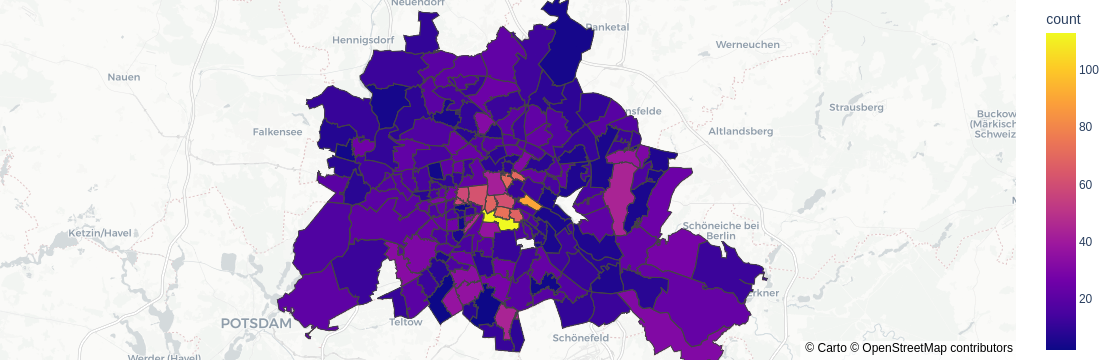

In [42]:
PlotService(analytics).density_plot(start= "01-01-2024", end = "02-02-2024")

/tmp/ipykernel_134821/2674303458.py:27: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



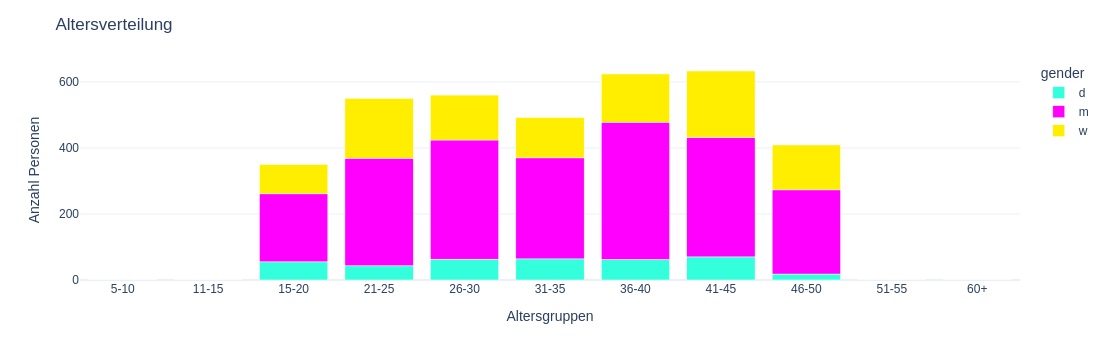

In [56]:
PlotService(analytics).age_histogram(start= "01-01-2024", end = "02-02-2024")

/tmp/ipykernel_134821/2248445997.py:30: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



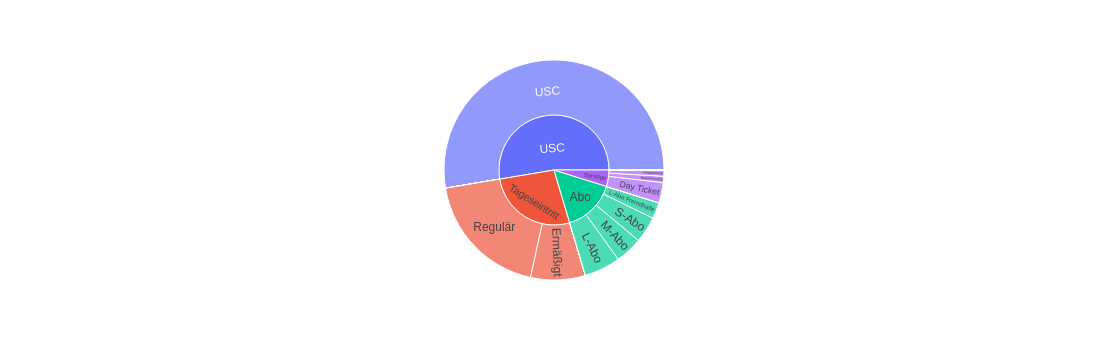

In [129]:
PlotService(analytics).sunburst_plot()